In [1]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import run_tests_params
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc read-aloud"><h2>--- Day 20: Donut Maze ---</h2><p>You notice a strange pattern on the surface of Pluto and land nearby to get a closer look. Upon closer inspection, you realize you've come across one of the famous space-warping mazes of the long-lost Pluto civilization!</p>
<p>Because there isn't much space on Pluto, the civilization that used to live here thrived by inventing a method for folding spacetime.  Although the technology is no longer understood, mazes like this one provide a small glimpse into the <span title="So really, this puzzle is more archaeology than math, right?">daily life of an ancient Pluto citizen</span>.</p>
<p>This maze is shaped like a <a href="https://en.wikipedia.org/wiki/Torus">donut</a>. Portals along the inner and outer edge of the donut can instantly teleport you from one side to the other.  For example:</p>
<pre><code>         A           
         A           
  #######.#########  
  #######.........#  
  #######.#######.#  
  #######.#######.#  
  #######.#######.#  
  #####  B    ###.#  
BC...##  C    ###.#  
  ##.##       ###.#  
  ##...DE  F  ###.#  
  #####    G  ###.#  
  #########.#####.#  
DE..#######...###.#  
  #.#########.###.#  
FG..#########.....#  
  ###########.#####  
             Z       
             Z       
</code></pre>
<p>This map of the maze shows solid walls (<code>#</code>) and open passages (<code>.</code>). Every maze on Pluto has a start (the open tile next to <code>AA</code>) and an end (the open tile next to <code>ZZ</code>). Mazes on Pluto also have portals; this maze has three pairs of portals: <code>BC</code>, <code>DE</code>, and <code>FG</code>. When on an open tile next to one of these labels, a single step can take you to the other tile with the same label. (You can only walk on <code>.</code> tiles; labels and empty space are not traversable.)</p>
<p>One path through the maze doesn't require any portals.  Starting at <code>AA</code>, you could go down 1, right 8, down 12, left 4, and down 1 to reach <code>ZZ</code>, a total of 26 steps.</p>
<p>However, there is a shorter path:  You could walk from <code>AA</code> to the inner <code>BC</code> portal (4 steps), warp to the outer <code>BC</code> portal (1 step), walk to the inner <code>DE</code> (6 steps), warp to the outer <code>DE</code> (1 step), walk to the outer <code>FG</code> (4 steps), warp to the inner <code>FG</code> (1 step), and finally walk to <code>ZZ</code> (6 steps). In total, this is only <em>23</em> steps.</p>
<p>Here is a larger example:</p>
<pre><code>                   A               
                   A               
  #################.#############  
  #.#...#...................#.#.#  
  #.#.#.###.###.###.#########.#.#  
  #.#.#.......#...#.....#.#.#...#  
  #.#########.###.#####.#.#.###.#  
  #.............#.#.....#.......#  
  ###.###########.###.#####.#.#.#  
  #.....#        A   C    #.#.#.#  
  #######        S   P    #####.#  
  #.#...#                 #......VT
  #.#.#.#                 #.#####  
  #...#.#               YN....#.#  
  #.###.#                 #####.#  
DI....#.#                 #.....#  
  #####.#                 #.###.#  
ZZ......#               QG....#..AS
  ###.###                 #######  
JO..#.#.#                 #.....#  
  #.#.#.#                 ###.#.#  
  #...#..DI             BU....#..LF
  #####.#                 #.#####  
YN......#               VT..#....QG
  #.###.#                 #.###.#  
  #.#...#                 #.....#  
  ###.###    J L     J    #.#.###  
  #.....#    O F     P    #.#...#  
  #.###.#####.#.#####.#####.###.#  
  #...#.#.#...#.....#.....#.#...#  
  #.#####.###.###.#.#.#########.#  
  #...#.#.....#...#.#.#.#.....#.#  
  #.###.#####.###.###.#.#.#######  
  #.#.........#...#.............#  
  #########.###.###.#############  
           B   J   C               
           U   P   P               
</code></pre>
<p>Here, <code>AA</code> has no direct path to <code>ZZ</code>, but it does connect to <code>AS</code> and <code>CP</code>. By passing through <code>AS</code>, <code>QG</code>, <code>BU</code>, and <code>JO</code>, you can reach <code>ZZ</code> in <em>58</em> steps.</p>
<p>In your maze, <em>how many steps does it take to get from the open tile marked <code>AA</code> to the open tile marked <code>ZZ</code>?</em></p>
</article>


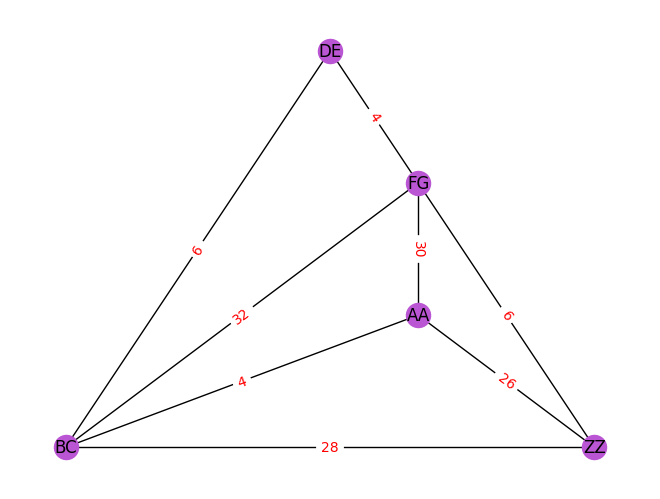

In [2]:
from collections import deque
from heapq import heappop, heappush
from re import finditer


class Maze:
    def __init__(self, s: str) -> None:
        self.grid = [l for l in s.splitlines() if l]
        self.rows, self.cols = len(self.grid), len(self.grid[0])

        self.portal_to_point, self.point_to_portal = self.get_portals()
        self.graph = self.make_graph()

    def make_graph(self) -> dict[str, dict[str, int]]:
        graph = {}

        for portal, points in self.portal_to_point.items():
            graph[portal] = {}
            for point in points:
                queue = deque([(0, *point)])
                seen = set()
                while queue:
                    d, r, c = queue.popleft()

                    seen.add((r, c))

                    for dr, dc in ((-1, 0), (0, 1), (1, 0), (0, -1)):
                        if (
                            0 <= r + dr < self.rows
                            and 0 <= c + dc < self.cols
                            and (r + dr, c + dc) not in seen
                            and self.grid[r + dr][c + dc] == "."
                        ):
                            if (r + dr, c + dc) in self.point_to_portal:
                                graph[portal][
                                    self.point_to_portal[(r + dr, c + dc)]
                                ] = (d + 1)
                            else:
                                queue.append((d + 1, r + dr, c + dc))

        return graph

    def get_portals(
        self,
    ) -> tuple[defaultdict[str, list[tuple[int, int]]], dict[tuple[int, int], str]]:
        portal_to_point = defaultdict(list)
        point_to_portal = {}

        for r, l in enumerate(self.grid):
            for m in finditer(r"[A-Z]+", l):
                if len(m.group()) == 2:  # horizontal
                    if (
                        0 <= m.start() - 1 < self.cols
                        and self.grid[r][m.start() - 1] == "."
                    ):
                        point_to_portal[(r, m.start() - 1)] = m.group()
                        portal_to_point[m.group()].append((r, m.start() - 1))
                    else:
                        point_to_portal[(r, m.end())] = m.group()
                        portal_to_point[m.group()].append((r, m.end()))
                elif len(m.group()) == 1:  # vertical
                    if (
                        r > 0
                        and self.grid[r - 1][m.start()] == "."
                        and self.grid[r + 1][m.start()].isupper()
                    ):
                        portal = self.grid[r][m.start()] + self.grid[r + 1][m.start()]
                        portal_to_point[portal].append((r - 1, m.start()))
                        point_to_portal[(r - 1, m.start())] = portal
                    elif (
                        r + 1 < self.rows
                        and self.grid[r + 1][m.start()] == "."
                        and self.grid[r - 1][m.start()].isupper()
                    ):
                        portal = self.grid[r - 1][m.start()] + self.grid[r][m.start()]
                        point_to_portal[(r + 1, m.start())] = portal
                        portal_to_point[portal].append((r + 1, m.start()))
                else:
                    raise ValueError(f"Wrong length: {m}")

        return portal_to_point, point_to_portal

    def shortest_path_from_AA_to_ZZ(self) -> int:
        heap = [(-1, "AA")]
        seen = set()

        while heap:
            d, current = heappop(heap)

            if current == "ZZ":
                return d

            if current in seen:
                continue

            seen.add(current)

            for neighbor, dd in self.graph[current].items():
                heappush(heap, (d + dd + 1, neighbor))

        return -1

    def plot_graph(self) -> None:
        G = nx.Graph()  # create an empty object

        G.add_nodes_from(self.graph.keys())
        G.add_edges_from(
            (fr, to) for fr, tos in self.graph.items() for to in tos.keys()
        )
        edge_labels = {
            (fr, to): w for fr, tos in self.graph.items() for to, w in tos.items()
        }

        pos = nx.planar_layout(G)

        nx.draw(G, pos, with_labels=True, node_color="MediumOrchid")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
        plt.show()
        plt.close()


example1 = """
         A           
         A           
  #######.#########  
  #######.........#  
  #######.#######.#  
  #######.#######.#  
  #######.#######.#  
  #####  B    ###.#  
BC...##  C    ###.#  
  ##.##       ###.#  
  ##...DE  F  ###.#  
  #####    G  ###.#  
  #########.#####.#  
DE..#######...###.#  
  #.#########.###.#  
FG..#########.....#  
  ###########.#####  
             Z       
             Z       
"""

m = Maze(example1)
m.plot_graph()
assert m.shortest_path_from_AA_to_ZZ() == 23

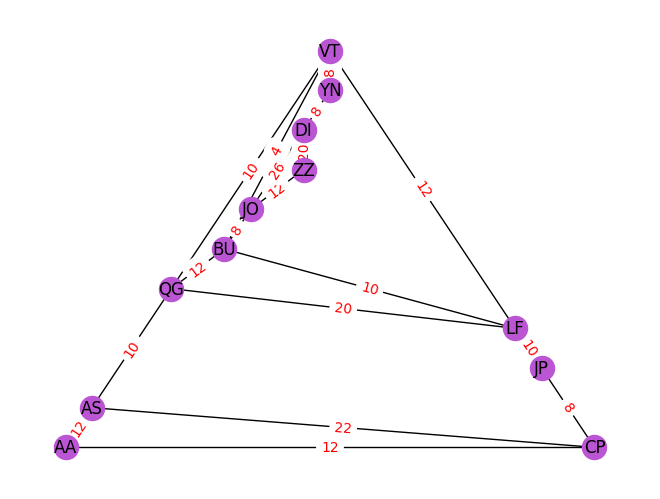

In [3]:
example2 = """
                   A               
                   A               
  #################.#############  
  #.#...#...................#.#.#  
  #.#.#.###.###.###.#########.#.#  
  #.#.#.......#...#.....#.#.#...#  
  #.#########.###.#####.#.#.###.#  
  #.............#.#.....#.......#  
  ###.###########.###.#####.#.#.#  
  #.....#        A   C    #.#.#.#  
  #######        S   P    #####.#  
  #.#...#                 #......VT
  #.#.#.#                 #.#####  
  #...#.#               YN....#.#  
  #.###.#                 #####.#  
DI....#.#                 #.....#  
  #####.#                 #.###.#  
ZZ......#               QG....#..AS
  ###.###                 #######  
JO..#.#.#                 #.....#  
  #.#.#.#                 ###.#.#  
  #...#..DI             BU....#..LF
  #####.#                 #.#####  
YN......#               VT..#....QG
  #.###.#                 #.###.#  
  #.#...#                 #.....#  
  ###.###    J L     J    #.#.###  
  #.....#    O F     P    #.#...#  
  #.###.#####.#.#####.#####.###.#  
  #...#.#.#...#.....#.....#.#...#  
  #.#####.###.###.#.#.#########.#  
  #...#.#.....#...#.#.#.#.....#.#  
  #.###.#####.###.###.#.#.#######  
  #.#.........#...#.............#  
  #########.###.###.#############  
           B   J   C               
           U   P   P               

"""

m = Maze(example2)
m.plot_graph()
assert m.shortest_path_from_AA_to_ZZ() == 58

In [4]:
with open("../input/day20.txt") as f:
    puzzle = f.read()


m = Maze(puzzle)
print(f"Part I: {m.shortest_path_from_AA_to_ZZ()}")

Part I: 692


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>692</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>Strangely, the exit isn't open when you reach it.  Then, you remember: the ancient Plutonians were famous for building <em>recursive spaces</em>.</p>
<p>The marked connections in the maze aren't portals: they <em>physically connect</em> to a larger or smaller copy of the maze. Specifically, the labeled tiles around the inside edge actually connect to a smaller copy of the same maze, and the smaller copy's inner labeled tiles connect to yet a <em>smaller</em> copy, and so on.</p>
<p>When you enter the maze, you are at the outermost level; when at the outermost level, only the outer labels <code>AA</code> and <code>ZZ</code> function (as the start and end, respectively); all other outer labeled tiles are effectively walls. At any other level, <code>AA</code> and <code>ZZ</code> count as walls, but the other outer labeled tiles bring you one level outward.</p>
<p>Your goal is to find a path through the maze that brings you back to <code>ZZ</code> at the outermost level of the maze.</p>
<p>In the first example above, the shortest path is now the loop around the right side. If the starting level is <code>0</code>, then taking the previously-shortest path would pass through <code>BC</code> (to level <code>1</code>), <code>DE</code> (to level <code>2</code>), and <code>FG</code> (back to level <code>1</code>). Because this is not the outermost level, <code>ZZ</code> is a wall, and the only option is to go back around to <code>BC</code>, which would only send you even deeper into the recursive maze.</p>
<p>In the second example above, there is no path that brings you to <code>ZZ</code> at the outermost level.</p>
<p>Here is a more interesting example:</p>
<pre><code>             Z L X W       C                 
             Z P Q B       K                 
  ###########.#.#.#.#######.###############  
  #...#.......#.#.......#.#.......#.#.#...#  
  ###.#.#.#.#.#.#.#.###.#.#.#######.#.#.###  
  #.#...#.#.#...#.#.#...#...#...#.#.......#  
  #.###.#######.###.###.#.###.###.#.#######  
  #...#.......#.#...#...#.............#...#  
  #.#########.#######.#.#######.#######.###  
  #...#.#    F       R I       Z    #.#.#.#  
  #.###.#    D       E C       H    #.#.#.#  
  #.#...#                           #...#.#  
  #.###.#                           #.###.#  
  #.#....OA                       WB..#.#..ZH
  #.###.#                           #.#.#.#  
CJ......#                           #.....#  
  #######                           #######  
  #.#....CK                         #......IC
  #.###.#                           #.###.#  
  #.....#                           #...#.#  
  ###.###                           #.#.#.#  
XF....#.#                         RF..#.#.#  
  #####.#                           #######  
  #......CJ                       NM..#...#  
  ###.#.#                           #.###.#  
RE....#.#                           #......RF
  ###.###        X   X       L      #.#.#.#  
  #.....#        F   Q       P      #.#.#.#  
  ###.###########.###.#######.#########.###  
  #.....#...#.....#.......#...#.....#.#...#  
  #####.#.###.#######.#######.###.###.#.#.#  
  #.......#.......#.#.#.#.#...#...#...#.#.#  
  #####.###.#####.#.#.#.#.###.###.#.###.###  
  #.......#.....#.#...#...............#...#  
  #############.#.#.###.###################  
               A O F   N                     
               A A D   M                     
</code></pre>
<p>One shortest path through the maze is the following:</p>
<ul>
<li>Walk from <code>AA</code> to <code>XF</code> (16 steps)</li>
<li>Recurse into level 1 through <code>XF</code> (1 step)</li>
<li>Walk from <code>XF</code> to <code>CK</code> (10 steps)</li>
<li>Recurse into level 2 through <code>CK</code> (1 step)</li>
<li>Walk from <code>CK</code> to <code>ZH</code> (14 steps)</li>
<li>Recurse into level 3 through <code>ZH</code> (1 step)</li>
<li>Walk from <code>ZH</code> to <code>WB</code> (10 steps)</li>
<li>Recurse into level 4 through <code>WB</code> (1 step)</li>
<li>Walk from <code>WB</code> to <code>IC</code> (10 steps)</li>
<li>Recurse into level 5 through <code>IC</code> (1 step)</li>
<li>Walk from <code>IC</code> to <code>RF</code> (10 steps)</li>
<li>Recurse into level 6 through <code>RF</code> (1 step)</li>
<li>Walk from <code>RF</code> to <code>NM</code> (8 steps)</li>
<li>Recurse into level 7 through <code>NM</code> (1 step)</li>
<li>Walk from <code>NM</code> to <code>LP</code> (12 steps)</li>
<li>Recurse into level 8 through <code>LP</code> (1 step)</li>
<li>Walk from <code>LP</code> to <code>FD</code> (24 steps)</li>
<li>Recurse into level 9 through <code>FD</code> (1 step)</li>
<li>Walk from <code>FD</code> to <code>XQ</code> (8 steps)</li>
<li>Recurse into level 10 through <code>XQ</code> (1 step)</li>
<li>Walk from <code>XQ</code> to <code>WB</code> (4 steps)</li>
<li>Return to level 9 through <code>WB</code> (1 step)</li>
<li>Walk from <code>WB</code> to <code>ZH</code> (10 steps)</li>
<li>Return to level 8 through <code>ZH</code> (1 step)</li>
<li>Walk from <code>ZH</code> to <code>CK</code> (14 steps)</li>
<li>Return to level 7 through <code>CK</code> (1 step)</li>
<li>Walk from <code>CK</code> to <code>XF</code> (10 steps)</li>
<li>Return to level 6 through <code>XF</code> (1 step)</li>
<li>Walk from <code>XF</code> to <code>OA</code> (14 steps)</li>
<li>Return to level 5 through <code>OA</code> (1 step)</li>
<li>Walk from <code>OA</code> to <code>CJ</code> (8 steps)</li>
<li>Return to level 4 through <code>CJ</code> (1 step)</li>
<li>Walk from <code>CJ</code> to <code>RE</code> (8 steps)</li>
<li>Return to level 3 through <code>RE</code> (1 step)</li>
<li>Walk from <code>RE</code> to <code>IC</code> (4 steps)</li>
<li>Recurse into level 4 through <code>IC</code> (1 step)</li>
<li>Walk from <code>IC</code> to <code>RF</code> (10 steps)</li>
<li>Recurse into level 5 through <code>RF</code> (1 step)</li>
<li>Walk from <code>RF</code> to <code>NM</code> (8 steps)</li>
<li>Recurse into level 6 through <code>NM</code> (1 step)</li>
<li>Walk from <code>NM</code> to <code>LP</code> (12 steps)</li>
<li>Recurse into level 7 through <code>LP</code> (1 step)</li>
<li>Walk from <code>LP</code> to <code>FD</code> (24 steps)</li>
<li>Recurse into level 8 through <code>FD</code> (1 step)</li>
<li>Walk from <code>FD</code> to <code>XQ</code> (8 steps)</li>
<li>Recurse into level 9 through <code>XQ</code> (1 step)</li>
<li>Walk from <code>XQ</code> to <code>WB</code> (4 steps)</li>
<li>Return to level 8 through <code>WB</code> (1 step)</li>
<li>Walk from <code>WB</code> to <code>ZH</code> (10 steps)</li>
<li>Return to level 7 through <code>ZH</code> (1 step)</li>
<li>Walk from <code>ZH</code> to <code>CK</code> (14 steps)</li>
<li>Return to level 6 through <code>CK</code> (1 step)</li>
<li>Walk from <code>CK</code> to <code>XF</code> (10 steps)</li>
<li>Return to level 5 through <code>XF</code> (1 step)</li>
<li>Walk from <code>XF</code> to <code>OA</code> (14 steps)</li>
<li>Return to level 4 through <code>OA</code> (1 step)</li>
<li>Walk from <code>OA</code> to <code>CJ</code> (8 steps)</li>
<li>Return to level 3 through <code>CJ</code> (1 step)</li>
<li>Walk from <code>CJ</code> to <code>RE</code> (8 steps)</li>
<li>Return to level 2 through <code>RE</code> (1 step)</li>
<li>Walk from <code>RE</code> to <code>XQ</code> (14 steps)</li>
<li>Return to level 1 through <code>XQ</code> (1 step)</li>
<li>Walk from <code>XQ</code> to <code>FD</code> (8 steps)</li>
<li>Return to level 0 through <code>FD</code> (1 step)</li>
<li>Walk from <code>FD</code> to <code>ZZ</code> (18 steps)</li>
</ul>
<p>This path takes a total of <em>396</em> steps to move from <code>AA</code> at the outermost layer to <code>ZZ</code> at the outermost layer.</p>
<p>In your maze, when accounting for recursion, <em>how many steps does it take to get from the open tile marked <code>AA</code> to the open tile marked <code>ZZ</code>, both at the outermost layer?</em></p>
</article>

</main>


In [5]:
from numbers import Real
from more_itertools import transpose


class RecursiveMaze:
    def __init__(self, s: str) -> None:
        self.grid = [list(l) for l in s.splitlines() if l]

        self.inner, self.outer = self.portals(self.grid)
        inner, outer = self.portals(list(transpose(self.grid)))
        self.inner |= {p: (c, r) for p, (r, c) in inner.items()}
        self.outer |= {p: (c, r) for p, (r, c) in outer.items()}

        self.graphs = self.create_graphs()

    def create_graphs(self) -> dict[tuple[str, bool], dict[tuple[str, bool], int]]:
        outer_inv = {point: (portal, True) for portal, point in self.outer.items()}
        inner_inv = {point: (portal, False) for portal, point in self.inner.items()}
        portals_inv = outer_inv | inner_inv

        graphs = {}

        for point, (portal, is_outer) in portals_inv.items():
            queue = deque([(0, portal, is_outer, point, frozenset())])

            graph = defaultdict(dict)

            while queue:
                d, portal_fr, is_outer_fr, point_fr, seen = queue.popleft()

                if point_fr in seen:
                    continue

                seen |= {point_fr}

                r, c = point_fr

                for dr, dc in ((-1, 0), (0, 1), (1, 0), (0, -1)):
                    point_to = r + dr, c + dc
                    if self.grid[r + dr][c + dc] == "." and point_to not in seen:
                        if point_to in portals_inv:
                            portal_to, is_outer_to = portals_inv[point_to]
                            graph[(portal_fr, is_outer_fr)][
                                (portal_to, is_outer_to)
                            ] = d
                        else:
                            queue.append(
                                (d + 1, portal_fr, is_outer_fr, point_to, seen)
                            )

            graphs |= graph

        return graphs

    def shortest_path_from_AA_to_ZZ(self) -> Real:
        # If no solution will run for ever!
        heap = [(0, 0, "AA", True)]

        while heap:
            d, level, portal_fr, is_outer_fr = heappop(heap)

            if level == 0 and portal_fr == "ZZ":
                return d

            for (portal_to, is_outer_to), dd in self.graphs[
                (portal_fr, is_outer_fr)
            ].items():
                if is_outer_to:
                    if level == 0 and portal_to == "ZZ":
                        heappush(heap, (d + dd + 1, 0, portal_to, True))
                    elif level != 0 and portal_to != "ZZ" and portal_to != "AA":
                        heappush(heap, (d + dd + 2, level - 1, portal_to, False))
                else:
                    heappush(heap, (d + dd + 2, level + 1, portal_to, True))

        return inf

    def portals(
        self, grid: list[list[str]]
    ) -> tuple[dict[str, tuple[int, int]], dict[str, tuple[int, int]]]:
        outer, inner = {}, {}
        for r, line in enumerate(grid):
            walls = 0
            for c in range(1, len(line) - 1):
                if (line[c] == " " or line[c].isupper()) and line[c - 1] in "#.":
                    walls += 1

                if (
                    walls == 0
                    and line[c - 1].isupper()
                    and line[c].isupper()
                    and line[c + 1] == "."
                ):
                    outer[line[c - 1] + line[c]] = r, c + 1
                elif (
                    walls == 1
                    and line[c - 1] == "."
                    and line[c].isupper()
                    and line[c + 1].isupper()
                ):
                    inner[line[c] + line[c + 1]] = r, c - 1
                elif (
                    walls == 1
                    and line[c - 1].isupper()
                    and line[c].isupper()
                    and line[c + 1] == "."
                ):
                    inner[line[c - 1] + line[c]] = r, c + 1
                elif (
                    walls == 2
                    and line[c - 1] == "."
                    and line[c].isupper()
                    and line[c + 1].isupper()
                ):
                    outer[line[c] + line[c + 1]] = r, c - 1

        return inner, outer

    def __repr__(self) -> str:
        return "\n".join("".join(l) for l in self.grid)


example1 = """
         A           
         A           
  #######.#########  
  #######.........#  
  #######.#######.#  
  #######.#######.#  
  #######.#######.#  
  #####  B    ###.#  
BC...##  C    ###.#  
  ##.##       ###.#  
  ##...DE  F  ###.#  
  #####    G  ###.#  
  #########.#####.#  
DE..#######...###.#  
  #.#########.###.#  
FG..#########.....#  
  ###########.#####  
             Z       
             Z       
"""

assert RecursiveMaze(example1).shortest_path_from_AA_to_ZZ() == 26

In [6]:
example2 = """
                   A               
                   A               
  #################.#############  
  #.#...#...................#.#.#  
  #.#.#.###.###.###.#########.#.#  
  #.#.#.......#...#.....#.#.#...#  
  #.#########.###.#####.#.#.###.#  
  #.............#.#.....#.......#  
  ###.###########.###.#####.#.#.#  
  #.....#        A   C    #.#.#.#  
  #######        S   P    #####.#  
  #.#...#                 #......VT
  #.#.#.#                 #.#####  
  #...#.#               YN....#.#  
  #.###.#                 #####.#  
DI....#.#                 #.....#  
  #####.#                 #.###.#  
ZZ......#               QG....#..AS
  ###.###                 #######  
JO..#.#.#                 #.....#  
  #.#.#.#                 ###.#.#  
  #...#..DI             BU....#..LF
  #####.#                 #.#####  
YN......#               VT..#....QG
  #.###.#                 #.###.#  
  #.#...#                 #.....#  
  ###.###    J L     J    #.#.###  
  #.....#    O F     P    #.#...#  
  #.###.#####.#.#####.#####.###.#  
  #...#.#.#...#.....#.....#.#...#  
  #.#####.###.###.#.#.#########.#  
  #...#.#.....#...#.#.#.#.....#.#  
  #.###.#####.###.###.#.#.#######  
  #.#.........#...#.............#  
  #########.###.###.#############  
           B   J   C               
           U   P   P               

"""
# rc = RecursiveMaze(example2)
# assert rc.shortest_path_from_AA_to_ZZ() == inf
# Doesn´t finnish

In [7]:
example3 = """
             Z L X W       C                 
             Z P Q B       K                 
  ###########.#.#.#.#######.###############  
  #...#.......#.#.......#.#.......#.#.#...#  
  ###.#.#.#.#.#.#.#.###.#.#.#######.#.#.###  
  #.#...#.#.#...#.#.#...#...#...#.#.......#  
  #.###.#######.###.###.#.###.###.#.#######  
  #...#.......#.#...#...#.............#...#  
  #.#########.#######.#.#######.#######.###  
  #...#.#    F       R I       Z    #.#.#.#  
  #.###.#    D       E C       H    #.#.#.#  
  #.#...#                           #...#.#  
  #.###.#                           #.###.#  
  #.#....OA                       WB..#.#..ZH
  #.###.#                           #.#.#.#  
CJ......#                           #.....#  
  #######                           #######  
  #.#....CK                         #......IC
  #.###.#                           #.###.#  
  #.....#                           #...#.#  
  ###.###                           #.#.#.#  
XF....#.#                         RF..#.#.#  
  #####.#                           #######  
  #......CJ                       NM..#...#  
  ###.#.#                           #.###.#  
RE....#.#                           #......RF
  ###.###        X   X       L      #.#.#.#  
  #.....#        F   Q       P      #.#.#.#  
  ###.###########.###.#######.#########.###  
  #.....#...#.....#.......#...#.....#.#...#  
  #####.#.###.#######.#######.###.###.#.#.#  
  #.......#.......#.#.#.#.#...#...#...#.#.#  
  #####.###.#####.#.#.#.#.###.###.#.###.###  
  #.......#.....#.#...#...............#...#  
  #############.#.#.###.###################  
               A O F   N                     
               A A D   M                     
"""


assert RecursiveMaze(example3).shortest_path_from_AA_to_ZZ() == 396

In [8]:
print(f"Part II: {RecursiveMaze(puzzle).shortest_path_from_AA_to_ZZ()}")

Part II: 8314


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>8314</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>

</main>
